PLAN

* One example of analytical system to generate a discrete spatial and temporal vector field, with grids in space and time

* Then we interpolate

_Energy_ 

\begin{equation*}
H(x, p_x, t) = \frac{1}{2} (p_x^2 - x^2 + \frac{1}{2} x^4)
\end{equation*}

_Vector field_ whith _time-dependent harmonic forcing_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial p_x} = f_1(x, p_x) = p_x \\
 \dot{p}_x &= -\frac{\partial H}{\partial x} + + \eta(t) = f_2(x, p_x) = x - x^3 + \eta(t)
 \end{align*}
 
where

\begin{align*}
\eta(t) = A \cdot sin(\omega t)
\end{align*}

with $A$ and $\omega$ the amplitude and the frequency of the perturbation.

* Provide files with fine discretisation and rough.

In [1]:
import pylds
import numpy as np
import matplotlib.pylab as plt
from pylds.base import compute_lagrangian_descriptor, perturb_field, fit_pes
from pylds.tools import draw_all_lds
from pylds.vector_fields import Duffing1D, Duffing1D_inverted, forcing

Define grid for sampling of data-points

* We require the spatial domain of the vector field to be larger than the domain where the LD is computed - otherwise this can lead to boarder effects on the interpolation

# Generate vector field data

In [5]:
import numpy as np
from pylds.base import perturb_field
from pylds.vector_fields import Duffing1D, forcing

In [6]:
x_min,x_max = [-2, 2]
y_min,y_max = [-1.5, 1.5]
t_min, t_max = [0, 10]
Nx, Ny, Nt = [21, 15, 11]

In [7]:
x_axis = np.linspace(x_min,x_max,Nx)
y_axis = np.linspace(y_min,y_max,Ny)
X, Y = np.meshgrid(x_axis, y_axis)

xy_points = np.column_stack([X.ravel(), Y.ravel()])
t_axis = np.linspace(t_min,t_max,Nt)

In [35]:
vector_field_original = Duffing1D

In [36]:
vector_field_frames = [vector_field_original(t, xy_points) for t in t_axis]
vector_field_frames = np.array(vector_field_frames)

# Interpolate vector field from data in time

In [29]:
from scipy import interpolate

In [30]:
vector_field_t_interp = interpolate.interp1d(t_axis, vector_field_frames.T, kind='cubic')

# Interpolate vector field from data in space

In [37]:
t0 = 0
v = vector_field_t_interp(t0)

In [38]:
vector_field1 = interpolate.interp2d(x_axis, y_axis, v[0], kind='cubic')
vector_field2 = interpolate.interp2d(x_axis, y_axis, v[1], kind='cubic')

vector_field = np.column_stack([vector_field1, vector_field2])

Evaluate on slice grid points

In [40]:
# Mesh parameters
xp_min,xp_max = [-1.9, 1.9]
yp_min,yp_max = [-1.4, 1.4]
Nxp, Nyp = [101, 121]

In [41]:
xp = np.linspace(xp_min,xp_max, Nxp)
yp = np.linspace(yp_min,yp_max, Nyp)

In [42]:
vector_field1(xp,yp)

array([[-1.53815639, -1.53159789, -1.51530087, ...,  1.31572385,
         1.36280857,  1.40762991],
       [-1.53800283, -1.53146696, -1.51521714, ...,  1.31608967,
         1.3636321 ,  1.40868804],
       [-1.53771149, -1.53121855, -1.51505827, ...,  1.31678374,
         1.36519463,  1.41069567],
       ...,
       [-1.41069567, -1.36519463, -1.31678374, ...,  1.51505827,
         1.53121855,  1.53771149],
       [-1.40868804, -1.3636321 , -1.31608967, ...,  1.51521714,
         1.53146696,  1.53800283],
       [-1.40762991, -1.36280857, -1.31572385, ...,  1.51530087,
         1.53159789,  1.53815639]])

# Put eveything together

* sample grid points or dimensions
* vector field frames - dimensions must match those of sample grid points 

In [1]:
import os
import h5py
import numpy as np
from pylds.base import perturb_field
from pylds.vector_fields import Duffing1D, forcing

In [15]:
def discretise_vector_field(sample_time_points, sample_coords, vector_field):
    """
    Returns a 1- or 2-dimensional array of function (potential energy) values on a grid of points.

    Parameters
    ----------
    coords : list of ndarrays,
        [x] or [x,y] contain coordinates.

    potential : function,
        Function/potential energy to be discretised.

    Returns
    -------
    pes_data : ndarray, shape(len(x)) or shape(len(y),len(x)),
        Array of function/potential values.
    """
    x, y = sample_coords
    X,Y = np.meshgrid(x,y,indexing='xy')
    sample_xy_points = np.column_stack([X.ravel(),Y.ravel()])
    
    vector_field_data = [vector_field(t, sample_xy_points) for t in sample_time_points]

    return np.array(vector_field_data)

In [16]:
x_min,x_max = [-2, 2]
y_min,y_max = [-1.5, 1.5]
t_min, t_max = [0, 10]
Nx, Ny, Nt = [40, 40, 50]

x_axis = np.linspace(x_min,x_max,Nx)
y_axis = np.linspace(y_min,y_max,Ny)
t_axis = np.linspace(t_min,t_max,Nt)

vector_field_original = Duffing1D

# perturbation_type, amplitude, freq = [1, 1, 1]
# perturbation_params = [perturbation_type, amplitude, freq]
# perturbation = lambda t, u: forcing(t, u, perturbation_params=perturbation_params)

vector_field = perturb_field(vector_field_original, forcing)

In [17]:
vector_field_data = discretise_vector_field(t_axis, [x_axis, y_axis], vector_field)

In [18]:
def generate_vector_field_data(sample_time_points, sample_coords, vector_field, filename):
    """
    Saves 1- or 2-dimensional array of function (potential energy) values on a grid of points to pylds/pes_files/filename.hdf5.
    File format fixed to HDF5 by default.

    Parameters
    ----------
    coords : list (or ndarray) of ndarrays
        [x] or [x,y] contain coordinates.

    potential : function
        Potential to be discretised.

    filename : string
    Name of hdf5 file to be saved.
    """

    vector_field_data = discretise_vector_field(sample_time_points, sample_coords, vector_field)
    
    dirname = 'pylds/vector_field_files'
    filepath = os.path.join(dirname, filename+'.hdf5')
    hf = h5py.File(filepath,'w')
    
    hf.create_dataset('sample_time', data=np.array(sample_time_points).astype('float64'))
    hf.create_dataset('sample_coords', data=np.array(sample_coords).astype('float64'))
    hf.create_dataset('vector_field_data', data=vector_field_data.astype('float64'))
    
    hf.close()

In [19]:
filename = 'Duffing_perturbed_vector_field_data'
generate_vector_field_data(t_axis, [x_axis, y_axis], vector_field, filename)

In [20]:
from scipy import interpolate

def fit_vector_field(filename):
    hf = h5py.File('pylds/vector_field_files/'+filename+'.hdf5','r')
    time = np.array(hf.get('sample_time'))
    coords = np.array(hf.get('sample_coords'))
    vector_field_data = np.array(hf.get('vector_field_data'))
    hf.close()
    
    def vector_field_wrap(v, u):
        return v(u[0],u[1]).squeeze()
    
    def vector_field_interpolated(t, u):
        x, y = u.T
        x_axis, y_axis = coords
        
        vector_field_t_interp = interpolate.interp1d(time, vector_field_data.T, kind='cubic')
        
        v_x = interpolate.interp2d(x_axis, y_axis, vector_field_t_interp(t)[0].T, kind='cubic')
        v_y = interpolate.interp2d(x_axis, y_axis, vector_field_t_interp(t)[1].T, kind='cubic')
        
        v_x_eval = np.array(list(map(lambda a: vector_field_wrap(v_x, a), u)))
        v_y_eval = np.array(list(map(lambda a: vector_field_wrap(v_y, a), u)))
        
        return np.column_stack([v_x_eval, v_y_eval])
    
    return vector_field_interpolated

In [21]:
filename = 'Duffing_perturbed_vector_field_data'
dis_vector_field = fit_vector_field(filename)

# Test fitted vector field

In [22]:
import matplotlib.pyplot as plt

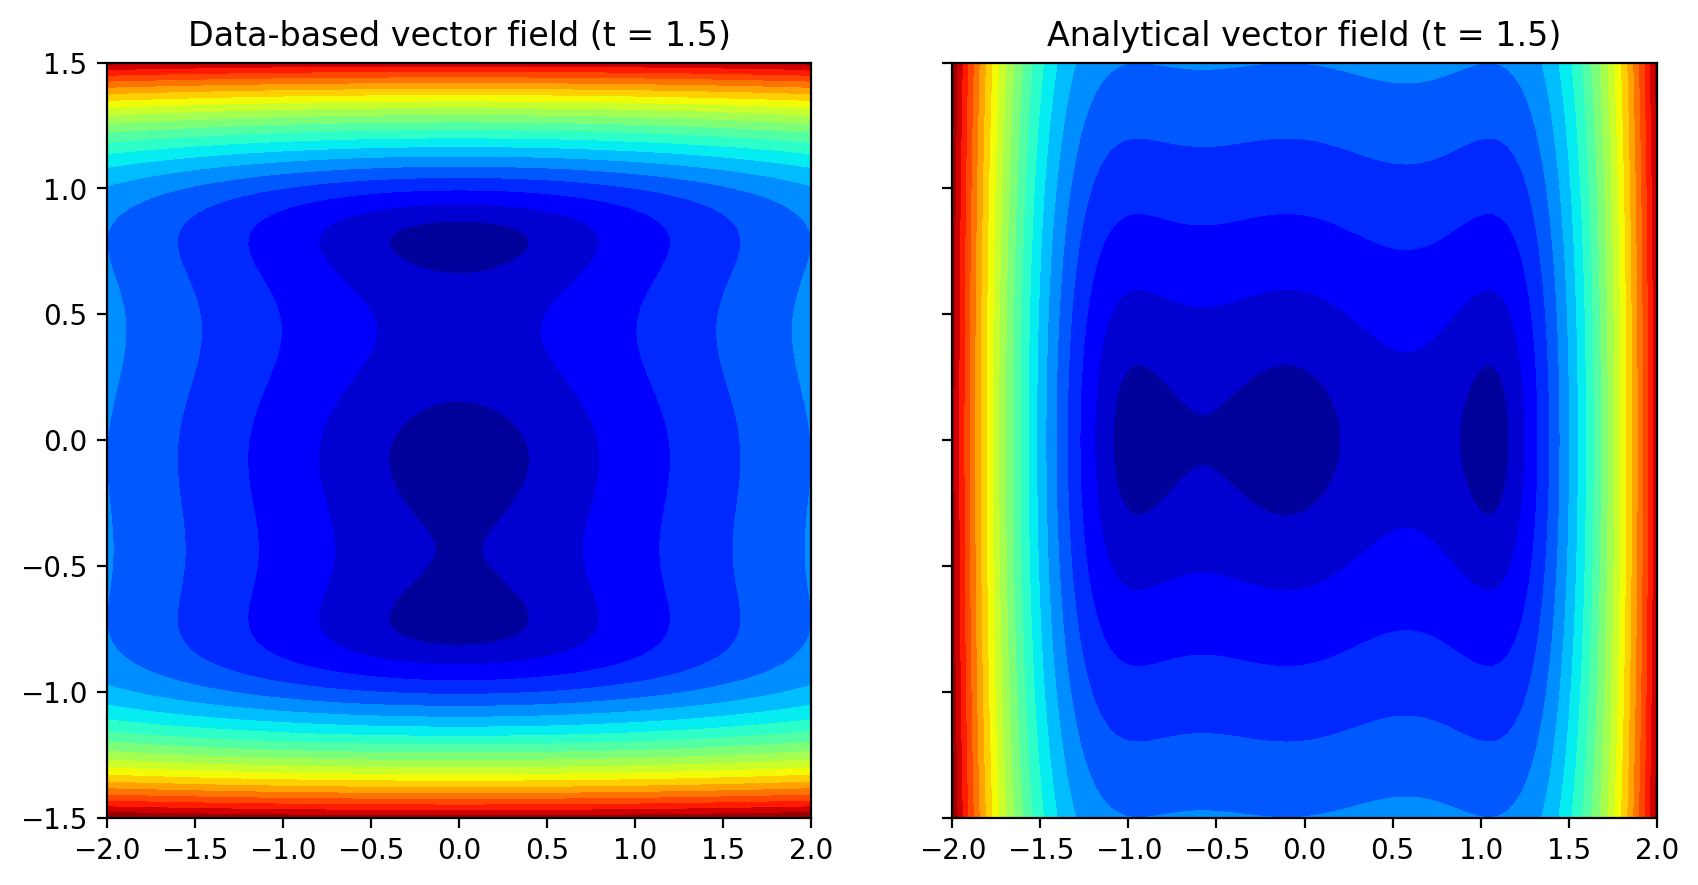

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5),dpi=200,sharex=True,sharey=True)

# Mesh parameters
xp_min,xp_max = [-2, 2]
yp_min,yp_max = [-1.5, 1.5]
Nxp, Nyp = [100, 100]
xp = np.linspace(xp_min,xp_max, Nxp)
yp = np.linspace(yp_min,yp_max, Nyp)

X,Y = np.meshgrid(xp, yp)
u = np.column_stack([X.ravel(), Y.ravel()])
######################################
t0 = 1.5
######################################
# DATA-FITTED vector field
C_dis = np.linalg.norm(dis_vector_field(t0, u),axis=1)

ax[0].contourf(xp, yp, C_dis.reshape(len(xp), len(yp)),cmap='jet',levels=20)
ax[0].set_title("Data-based vector field (t = "+str(t0)+")")

######################################
# ORGINAL non-autonomous vector field
C = np.linalg.norm(vector_field(t0, u),axis=1)

ax[1].contourf(xp, yp, C.reshape(len(xp), len(yp)),cmap='jet',levels=20)
ax[1].set_title("Analytical vector field (t = "+str(t0)+")")

plt.show()

# Lagrangian Descriptor

In [28]:
from pylds.base import compute_lagrangian_descriptor
from pylds.tools import draw_all_lds

In [29]:
# Integration parameters
tau = 8

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [30]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]

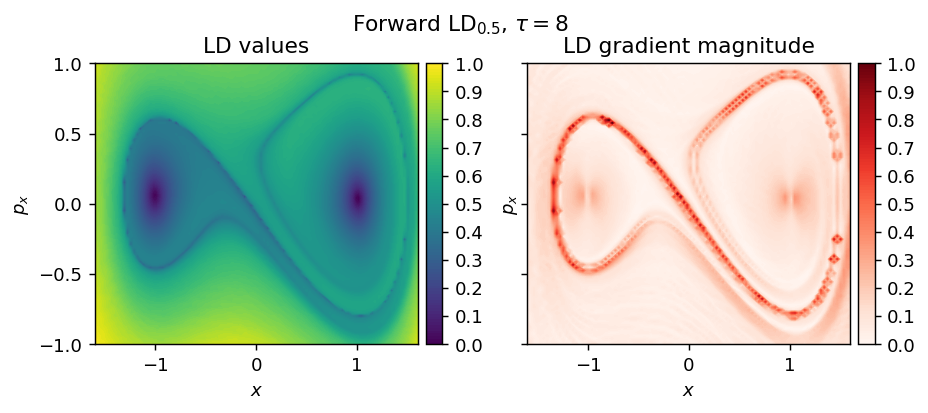

In [31]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
figs = draw_all_lds(LD_forward, [], grid_parameters, tau, p_value, interactive=False)

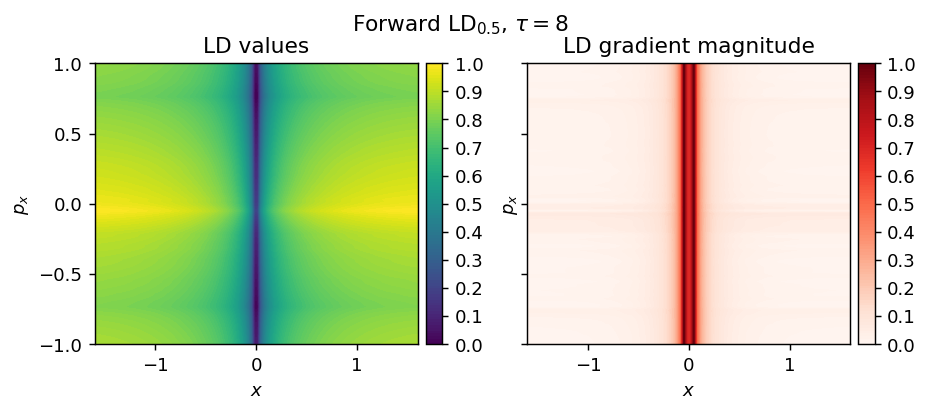

In [32]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, discretised_vector_field, tau, p_value)
figs = draw_all_lds(LD_forward, [], grid_parameters, tau, p_value, interactive=False)

TypeError: Length of x (21) must match number of columns in z (15)

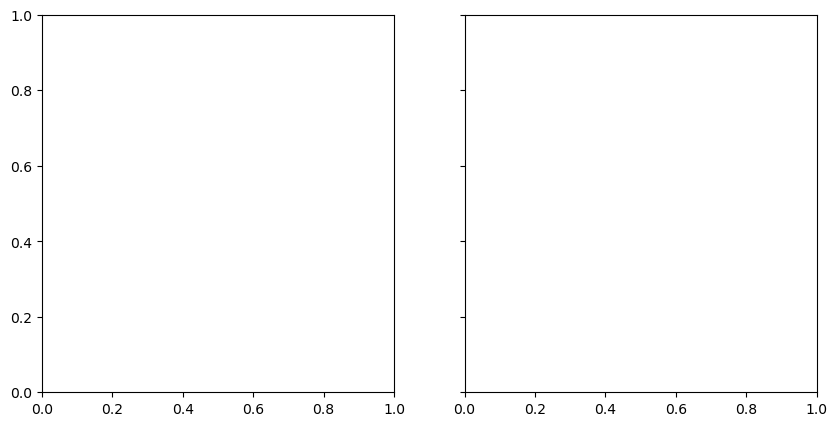

In [40]:
fig,ax = plt.subplots(1,2,figsize=(10,5) ,dpi=100, sharex=True, sharey=True)

C = np.linalg.norm(vector_field_frames[0],axis=1)
u, v = vector_field_frames[0].T
ax[0].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[0].quiver(points.T[0], points.T[1], u, v, zorder=100)

C = np.linalg.norm(vector_field_frames[10],axis=1)
u, v = vector_field_frames[10].T
ax[1].contourf(x, y, C.reshape(len(x), len(y)),cmap='jet',levels=20)
ax[1].quiver(points.T[0], points.T[1], u, v, zorder=100)

plt.show()

SANITY TEST about precision

In [43]:
for t0 in np.linspace(t_min, t_max, 6):
    test = (vector_field(t0, points).T == vector_field_interp(t0)).all()
    diff = vector_field(t0, points).T - vector_field_interp(t0)
    print(t0, test, diff.min(), diff.max())

0.0 True 0.0 0.0
2.0 False -8.881784197001252e-16 8.881784197001252e-16
4.0 False -8.881784197001252e-16 4.440892098500626e-16
6.0 False -8.881784197001252e-16 2.220446049250313e-16
8.0 False -4.440892098500626e-16 8.881784197001252e-16
10.0 True 0.0 0.0
